<a href="https://colab.research.google.com/github/jacheung/still-learning/blob/master/pole_tracker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
import os
import glob

import cv2
import numpy as np
import time
import re 

import h5py
import matplotlib.pyplot as plt

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Data prepare: load video directory and images


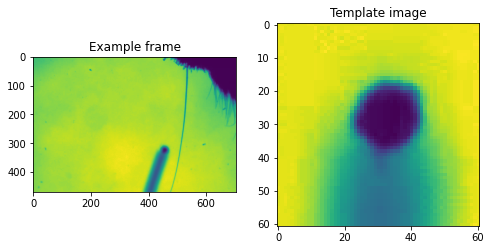

In [ ]:
# video/template directories 
video_directory = '/content/gdrive/My Drive/Colab data/Samson_C_T_vids/'
video_files = glob.glob(os.path.join(video_directory, '*.mp4'))
cap = cv2.VideoCapture(video_files[0])
if (cap.isOpened() == False):
  print('error opening video file')

template_directory = '/content/gdrive/My Drive/Colab data/trialFramesNPY/'
template_files =  glob.glob(os.path.join(template_directory, '*.npy'))
template = np.load(template_files[0])
template_img = template[0].astype(np.float32)

# plot the sample image
plt.figure(figsize = (8,8))
ret, frame = cap.read()
img_raw = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
img_raw = img_raw.astype(np.float32)
plt.subplot(1,2,1)
plt.imshow(img_raw)
plt.title('Example frame')

plt.subplot(1,2,2)
plt.imshow(template_img)
plt.title('Template image')

plt.show()

## Build Functions: for template and frame matching


In [ ]:
def crop_image(image, crop_values, inflation = 1):
  """ 
  This is an accessory function to pole_tracker to improve tracking speed. This crops the initial large image into a smaller one, based on the inflation rate. 
  Inflation rate of 1 = 3 x 3 template image size around the first guessed pole location. 
  """
  crop_top_left = crop_values['top_left'] - (np.array(crop_values['template_shape']) * inflation)
  crop_bottom_right = crop_values['bottom_right'] + (np.array(crop_values['template_shape']) * inflation)

  # You cannot crop larger than the size of the image. Defaults to max value. So no need to worry about inflation being too high. 
  cropped_image = image[crop_top_left[1]:crop_bottom_right[1], crop_top_left[0]:crop_bottom_right[0]]

  return cropped_image 

In [ ]:
# define function to find template image for each frame
def pole_tracker(video_directory, template, match_method):
  """ 
  this function scans a template image across each frame of the video to identify the pole location. 
  This assumes there is a pole at each frame. Cropping optimizes scanning by ~80% and uses the first frame 
  as a point of reference. 
  """
  # width and height of img_stacks will be that of template (61x61)
  w, h = template.shape[::-1]

  # open video at directory 
  video = cv2.VideoCapture(video_directory)
  if (video.isOpened() == False):
    print('error opening video file')

  fno = 0
  img_list = []
  loc_list = []
  success, frame = video.read()
  method = eval(match_method)

  while success:
    # preprocess image
    if 'crop_values' in locals():
      frame = crop_image(frame, crop_values, inflation = 1)
    img_raw = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    img_raw = img_raw.astype(np.float32)
    img = img_raw.copy()

    # Apply template Matching
    res = cv2.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # get coordinates of matched target
    top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    if 'crop_values' in locals():
      # readjusting location to main image
      max_loc = max_loc + np.array(crop_values['top_left']) - np.array(crop_values['template_shape'])
    else:
      crop_values = {'top_left': top_left, 'bottom_right': bottom_right, 'template_shape': template.shape}

    # crop image and store
    crop_img = img[top_left[1]:bottom_right[1], top_left[0]:bottom_right[0]]
    img_list.append(crop_img)
    loc_list.append(max_loc)

    # iterate to next frame and crop using current details
    fno += 1
    success, frame = video.read()

  img_stack = np.array(img_list)
  loc_stack = np.array(loc_list)
  return img_stack, loc_stack


In [ ]:
def plot_pole_center(video_directory, template_img, location_stack):
  video = cv2.VideoCapture(video_directory)
  success, frame = video.read()
  location_stack = location_stack + np.array(template_img.shape)/2

  plt.imshow(frame)
  plt.scatter(location_stack[:,0], location_stack[:,1], s=.2, c='r')
  plt.show()

  # threshold in pixels
  threshold = 50 
  distance_from_mean = np.sum(np.abs(location_stack - np.mean(location_stack,axis=0)),axis=1)
  exceed_threshold = np.mean(distance_from_mean < threshold) * 100
  print(str(np.round(exceed_threshold,2)) + '% of the pole locations are within ' + str(threshold) + ' pixels from the mean pole location.')


In [ ]:
def extract_trial_number(template, video_file):
  output_list = [li for li in difflib.ndiff(template, video) if li[0] != ' ']
  digits = [re.sub("\D", "", k) for k in output_list if '+' in k]
  trial_number = [''.join(digits)]
  return trial_number

## Match and plot identified locations

Runtime : 0.1462920904159546 mins


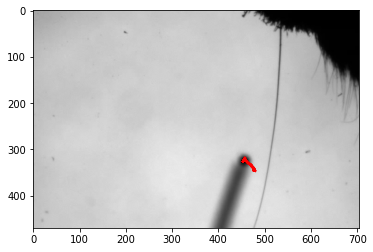

100.0% of the pole locations are within 50 pixels from the mean pole location.
Runtime : 0.0033803979555765786 mins


In [ ]:
# build image stack for one video file
start = time.time()

video_dir = video_files[0]
img_stack, loc_stack = pole_tracker(video_dir, template_img, match_method = 'cv2.TM_CCOEFF')

elapsed = time.time() - start
print('Runtime : ' + str(elapsed/60) + ' mins')

# plot image stack for one video file
plot_pole_center(video_dir, template_img, loc_stack)


In [ ]:
# compose values to populate H5 file for predictions

# create image stack
final_stack = []
start = time.time()
for video in video_files:
  print(video)
  img_stack, loc_stack = pole_tracker(video, template_img, match_method = 'cv2.TM_CCOEFF')
  final_stack.extend(img_stack)
elapsed = time.time() - start
print('Pole tracker runtime : ' + str(elapsed/60) + ' mins')

# pull trial numbers and frame numbers
trial_nums = list(map(lambda s: re.search("^.*-([0-9]+)\.", s).group(1), video_files))
frame_nums = list(map(lambda s: cv2.VideoCapture(s).get(7), video_files))

tnf = np.vstack([np.array(list(trial_nums)).astype(int), 
           np.array(list(frame_nums))])

# populating which trial each frame is in 
fnn = []
for a,b in zip(list(trial_nums),list(frame_nums)):
  fnn = np.concatenate([fnn,np.repeat(int(a),b)])

assert(len(fnn) == len(final_stack))

# populating "labels" with -1
labels = np.ones(img_stack.shape[0]) * -1

# populating whether pole "in_range" with nan values
in_range = np.empty(labels.shape)
in_range[:] = np.nan

assert(len(fnn) == len(final_stack))

/content/gdrive/My Drive/Colab data/Samson_C_T_vids/AH1118X25032020ses330-214.mp4
/content/gdrive/My Drive/Colab data/Samson_C_T_vids/AH1118X25032020ses330-204.mp4
/content/gdrive/My Drive/Colab data/Samson_C_T_vids/AH1118X25032020ses330-192.mp4
/content/gdrive/My Drive/Colab data/Samson_C_T_vids/AH1118X25032020ses330-189.mp4
/content/gdrive/My Drive/Colab data/Samson_C_T_vids/AH1118X25032020ses330-177.mp4
/content/gdrive/My Drive/Colab data/Samson_C_T_vids/AH1118X25032020ses330-176.mp4
Pole tracker runtime : 0.9700725277264913 mins


## Save session as H5 data




In [ ]:
file_name = re.search("([^\/]+)\-",video_files[0])[0]
path_with_name = file_name + '.h5'
print('file will be saved in video directory under the name ' + path_with_name)
hf = h5py.File(video_directory + file_name + '.h5', 'w')


file will be saved in video directory under the name AH1118X25032020ses330-.h5


In [ ]:
file_name = re.search("([^\/]+)\-",video_files[0])[0]
file_name

'AH1118X25032020ses330-'

In [ ]:
hf.create_dataset('file_name_nums', data=fnn)
hf.create_dataset('images', data=img_stack)
hf.create_dataset('labels', data=labels)
hf.create_dataset('trial_nums_and_frame_nums', data = tnf)
hf.create_dataset('in_range', data = in_range)

hf.close()

## Test bed for template matching methods

(48, 256) (109, 317)


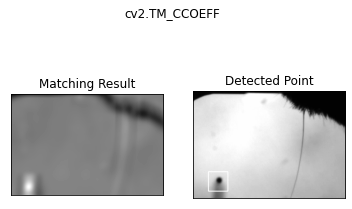

(48, 256) (109, 317)


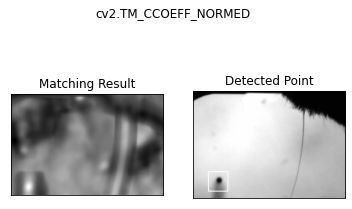

(128, 80) (189, 141)


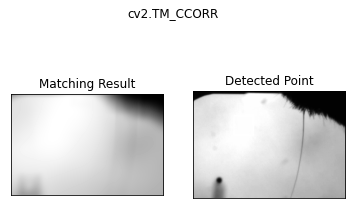

(48, 256) (109, 317)


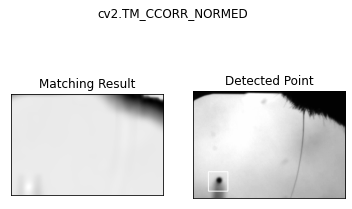

(47, 261) (108, 322)


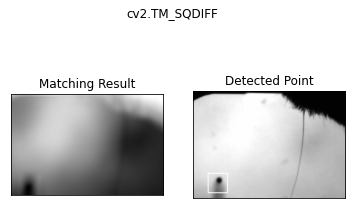

(48, 260) (109, 321)


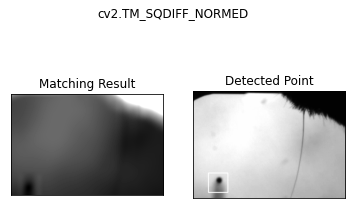

In [ ]:
# template matching method test bed
w, h = template_img.shape[::-1]

  # Apply template Matching
methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
            'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']

for meth in methods:
    img = img2.copy()
    method = eval(meth)

    # Apply template Matching
    res = cv2.matchTemplate(img,template_img,method)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv2.TM_SQDIFF, cv2.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)

    cv2.rectangle(img,top_left, bottom_right, 255, 2)

    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)

    plt.show()